In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from load_drop_data import (
    load_week_n_sell_data,
    drop_incomplete_sell_data
)

In [2]:
def date_to_weekday_am_pm(date):
    """Convert date to weekday followed by AM or PM
    
    Args:
        date (datetime): date when a given turnip price was observed
        
    Returns:
        weekday_am_pm (str): weekday AM/PM e.g. 'Monday AM'
    """
    
    weekday = date.strftime('%A')
    time_of_day = date.strftime('%p')
    
    weekday_am_pm = weekday + ' ' + time_of_day
    return weekday_am_pm

def datetime_to_weekday(data):
    """Use the column datetime_observed and function date_to_weekday_am_pm 
    to create the column weekday_observed
    
    Args:
        data (datetime): 
            contains turnip selling prices loaded into a dataframe using 
            get_week_n_sell_data
        
    Returns:
        data (dataframe): 
            contains the original data in addition to a column indicating 
            the weekday and time of day (AM/PM) for each price observation 
    """
    
    weekday_observed = data['datetime_observed'].apply(date_to_weekday_am_pm)
    data['weekday_observed'] = weekday_observed
    return data

def pivot(data, is_combined_data=True):
    """Pivot the data

    Args:
        data (dataframe):
            contains user_id, island_id, turnip selling prices along with 
            weekday_observed
    
    Returns:
        pivot_table (dataframe):
            pivot table of the data with incremented trend numbers in place 
            of user_id and island_id
             ______________________________________________________
            |     -    | Monday AM | Monday PM | ... | Saturday PM |
            | trend_id |     -     |     -     | ... |      -      |
            |     0    |   price   |   price   | ... |    price    |
    """
    
    not_combined_data = not(is_combined_data)
    if (not_combined_data):
        index=['user_id', 'island_id']
    else:
        index='trend_id'
        
    pivot_table = pd.pivot_table(
        data=data,
        values='price',
        index=index,
        columns='weekday_observed'
    )
    
    # correct weekday order
    column_names = data['weekday_observed'].unique()
    pivot_table = pivot_table.reindex(column_names, axis=1)
    
    if (not_combined_data):
        # drop user_id, island_id
        pivot_table.reset_index(drop=True, inplace=True)
    
    return pivot_table

def combine(list_of_data):
    """Combine weekly turnip prices
    
    Args:
        list_of_data (list): 
            contains price data for various weeks
        
    Returns:
        combined_data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    """
    
    pivot_tables = [
        pivot(data, is_combined_data=False) 
        for data in list_of_data
    ]
    
    combined_data = pd.concat(pivot_tables)
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.reset_index(inplace=True)
    
    combined_data = combined_data.melt(id_vars='index', value_name='price')
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.rename(columns={'index': 'trend_id'}, inplace=True)
    
    return combined_data

def get_decreasing_trend_ids(data):
    """Return the trend_id of decreasing trends
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    
    Returns:
        decreasing_trend_ids (array): 
            contains the trend_id of decreasing trends
    """
    
    pivot_table = pivot(data, is_combined_data=True)
    pivot_table = pivot_table.to_numpy()
    is_decreasing = np.all(pivot_table[:, 1:] < pivot_table[:, :-1], axis=1)
    decreasing_trend_ids = np.where(is_decreasing)[0]
    return decreasing_trend_ids

def get_spike_trend_ids(data):
    """Return the trend_id of trends with spikes
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    
    Returns:
        spike_trend_ids (array): 
            contains the trend_id of trends with spikes
    """
    
    pivot_table = pivot(data, is_combined_data=True)
    max_price = pivot_table.max(axis=1)
    
    # above 95th percentile from data_exploration
    is_spike = max_price > 177 

    spike_trend_ids = np.where(is_spike)[0]
    return spike_trend_ids

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
num_weeks = 4

sell_data = [
    load_week_n_sell_data(week=week_num, connection=connection) 
    for week_num in range(1, num_weeks + 1)
]    
sell_data = [drop_incomplete_sell_data(data) for data in sell_data]
sell_data = [datetime_to_weekday(data) for data in sell_data]

In [6]:
combined_sell_data = combine(sell_data)
xticks = combined_sell_data['weekday_observed'].unique()

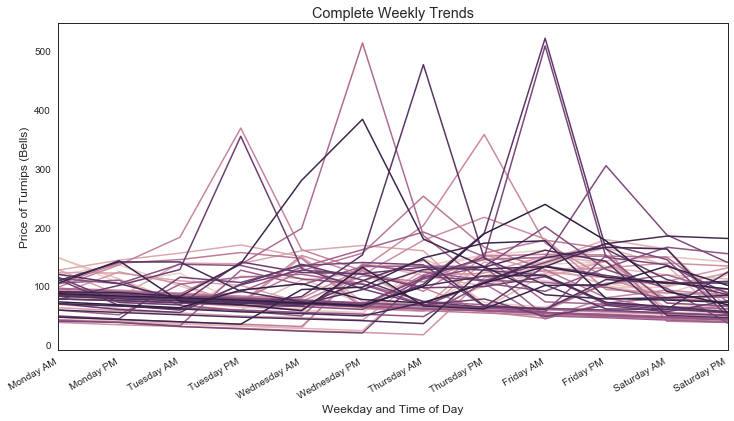

In [7]:
plt.figure(figsize=(12, 6))
combined_sell_data_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id',
    data=combined_sell_data, 
    sort=False,
    legend=False
)
combined_sell_data_plot.set(
    title='Complete Weekly Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
combined_sell_data_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

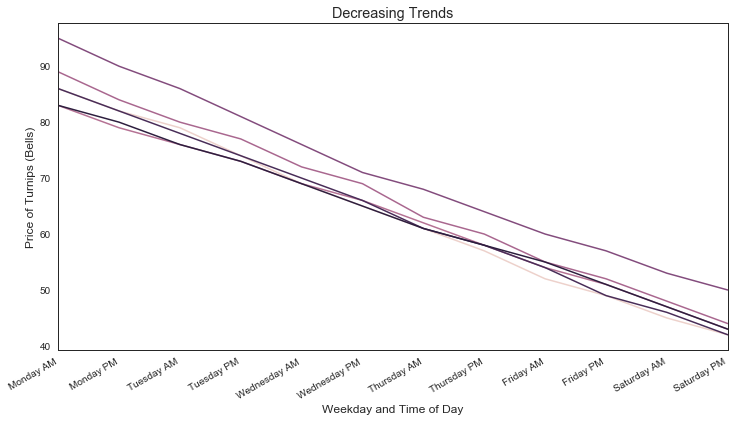

In [8]:
trend_id = combined_sell_data['trend_id']
y_min = combined_sell_data['price'].min()
y_max = combined_sell_data['price'].max()

decreasing_trend_ids = get_decreasing_trend_ids(combined_sell_data)
decreasing_trend_indices = combined_sell_data.index[trend_id.isin(decreasing_trend_ids)]

plt.figure(figsize=(12, 6))
decreasing_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=combined_sell_data.loc[decreasing_trend_indices, :], 
    sort=False,
    legend=False
)
decreasing_trend_plot.set(
    title='Decreasing Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
decreasing_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

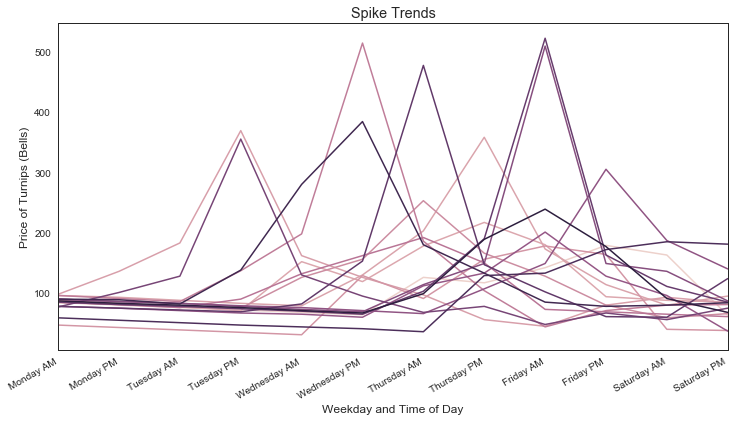

In [9]:
spike_trend_ids = get_spike_trend_ids(combined_sell_data)
spike_trend_indices = combined_sell_data.index[trend_id.isin(spike_trend_ids)]

plt.figure(figsize=(12, 6))
spike_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=combined_sell_data.loc[spike_trend_indices, :], 
    sort=False,
    legend=False
)
spike_trend_plot.set(
    title='Spike Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
spike_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

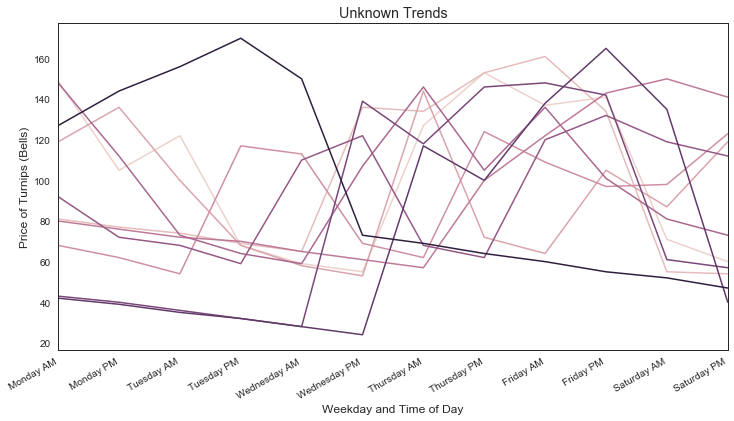

In [10]:
unknown_trend_indices = combined_sell_data.index[
    ~trend_id.isin(spike_trend_ids) & 
    ~trend_id.isin(decreasing_trend_ids)
]

initial_index = 0
num_samples = 10

# isolate unknown trends
unknown_trends = combined_sell_data.loc[unknown_trend_indices, :]

# pivot unnknown trends
unknown_trend_pivot = pivot(unknown_trends, is_combined_data=True)

# slice unknown trends
unknown_trend_pivot_subset = unknown_trend_pivot[initial_index: initial_index + num_samples]

# convert slice back to original form
unknown_trend_subset = unknown_trend_pivot_subset.reset_index()
unknown_trend_subset = unknown_trend_subset.melt(id_vars='trend_id', value_name='price')

plt.figure(figsize=(12, 6))
unknown_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=unknown_trend_subset, 
    sort=False,
    legend=False
)
unknown_trend_plot.set(
    title='Unknown Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
unknown_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()